<a href="https://colab.research.google.com/github/plue1011/PyTorch/blob/master/%E8%A9%B3%E8%A7%A3%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0/chap5/sin.ipynbsin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.1.5.4 RNN - PyTorch (sin波)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optimizers

In [0]:
class RNN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.l1 = nn.RNN(1, hidden_dim,
                         nonlinearity='tanh',
                         batch_first=True)
        self.l2 = nn.Linear(hidden_dim, 1)

        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0)

    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:, -1])
        return y

In [0]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [0]:
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# 1. データの準備

def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0,
                                      size=len(x))
    return sin(x) + noise

T = 100
f = toy_problem(T).astype(np.float32)
length_of_sequences = len(f)
maxlen = 25

x = []
t = []

for i in range(length_of_sequences - maxlen):
    x.append(f[i:i+maxlen])
    t.append(f[i+maxlen])

x = np.array(x).reshape(-1, maxlen, 1)
t = np.array(t).reshape(-1, 1)

x_train, x_val, t_train, t_val = \
    train_test_split(x, t, test_size=0.2, shuffle=False)

'''
2. モデルの構築
'''
model = RNN(50).to(device)

'''
3. モデルの学習
'''
criterion = nn.MSELoss(reduction='mean')
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), amsgrad=True)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

epochs = 1000
batch_size = 100
n_batches_train = x_train.shape[0] // batch_size + 1
n_batches_val = x_val.shape[0] // batch_size + 1
hist = {'loss': [], 'val_loss': []}
es = EarlyStopping(patience=10, verbose=1)

for epoch in range(epochs):
    train_loss = 0.
    val_loss = 0.
    x_, t_ = shuffle(x_train, t_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = train_step(x_[start:end], t_[start:end])
        train_loss += loss.item()

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = val_step(x_val[start:end], t_val[start:end])
        val_loss += loss.item()

    train_loss /= n_batches_train
    val_loss /= n_batches_val

    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)

    print('epoch: {}, loss: {:.3}, val_loss: {:.3f}'.format(
        epoch+1,
        train_loss,
        val_loss
    ))

    if es(val_loss):
        break

epoch: 1, loss: 0.515, val_loss: 0.675
epoch: 2, loss: 0.409, val_loss: 0.592
epoch: 3, loss: 0.338, val_loss: 0.505
epoch: 4, loss: 0.271, val_loss: 0.400
epoch: 5, loss: 0.234, val_loss: 0.288
epoch: 6, loss: 0.164, val_loss: 0.179
epoch: 7, loss: 0.112, val_loss: 0.105
epoch: 8, loss: 0.0762, val_loss: 0.067
epoch: 9, loss: 0.052, val_loss: 0.051
epoch: 10, loss: 0.0394, val_loss: 0.043
epoch: 11, loss: 0.0289, val_loss: 0.032
epoch: 12, loss: 0.0248, val_loss: 0.023
epoch: 13, loss: 0.0222, val_loss: 0.022
epoch: 14, loss: 0.0253, val_loss: 0.028
epoch: 15, loss: 0.0231, val_loss: 0.026
epoch: 16, loss: 0.024, val_loss: 0.018
epoch: 17, loss: 0.0186, val_loss: 0.013
epoch: 18, loss: 0.0162, val_loss: 0.016
epoch: 19, loss: 0.0167, val_loss: 0.018
epoch: 20, loss: 0.0159, val_loss: 0.017
epoch: 21, loss: 0.013, val_loss: 0.014
epoch: 22, loss: 0.0133, val_loss: 0.012
epoch: 23, loss: 0.0107, val_loss: 0.011
epoch: 24, loss: 0.00935, val_loss: 0.011
epoch: 25, loss: 0.00823, val_loss

In [0]:
# 4. モデルの評価
model.eval()

# sin波の予測
sin = toy_problem(T, ampl=0.)
gen = [None for i in range(maxlen)]

z = x[:1]

for i in range(length_of_sequences - maxlen):
    z_ = torch.Tensor(z[-1:]).to(device)
    preds = model(z_).data.cpu().numpy()
    z = np.append(z, preds)[1:]
    z = z.reshape(-1, maxlen, 1)
    gen.append(preds[0, 0])

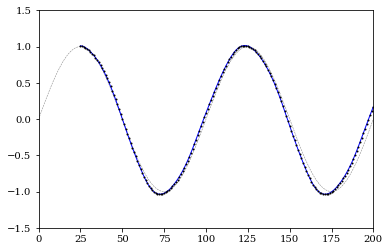

In [7]:
# 予測値を可視化
fig = plt.figure()
plt.rc('font', family='serif')
plt.xlim([0, 2*T])
plt.ylim([-1.5, 1.5])
plt.plot(range(len(f)), sin,
          color='gray',
          linestyle='--', linewidth=0.5)
plt.plot(range(len(f)), gen,
          color='b', linewidth=1,
          marker='o', markersize=1, markerfacecolor='black',
          markeredgecolor='black')
# plt.savefig('output.jpg')
plt.show()